This script produces a table of PMC paper IDs matched to the SRA or GEO datasets they contain, and metadata about those datasets.

In [1]:
# import required modules
import numpy as np
import pandas as pd
from collections import Counter
import statistics

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

Step I: Import table from create_metadata_matrix.ipynb

In [2]:
allFactors = pd.read_csv('../data_tables/metadataMatrix.csv')

Step II: Conduct analysis on this table, producing new metrics

In [3]:
# add a column with the total use count of each converted_accession ID

# first, create a new dataframe with no double-counted accessions
# justAcc includes all unique pairings of PMC ID and Series/Study accession
justAcc = allFactors.loc[:, ['pmc_ID', 'converted_accession']]
justAcc = justAcc.drop_duplicates()

rc = Counter(justAcc['converted_accession'])
reuse_counts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
reuse_counts.columns = ['converted_accession', 'total_use_count']
reuse_counts

,converted_accession,total_use_count
0,GSE506,64
1,GSE45534,1
2,GSE5281,43
3,GSE67036,1
4,GSE1297,32
...,...,...
35221,GSE85841,1
35222,GPL20115,1
35223,GSE73953,1
35224,GSE14795,1


In [4]:
# merge reuse counts onto table
allFactors = pd.merge(allFactors, reuse_counts, how = 'left', on = 'converted_accession')
allFactors

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,total_use_count
0,Alzheimers_Res_Ther,PMC3707052,GSM1,GSE506,GEO,2013-04-18,2000-09-28,Homo sapiens,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,64
1,Alzheimers_Res_Ther,PMC3706879,GSE45534,GSE45534,GEO,2013-05-14,2004-05-25,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1
2,Alzheimers_Res_Ther,PMC4255636,GSE5281,GSE5281,GEO,2014-11-02,2003-11-07,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,43
3,Alzheimers_Res_Ther,PMC4731966,GSE67036,GSE67036,GEO,2016-01-28,2013-05-06,Rattus norvegicus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1
4,Alzheimers_Res_Ther,PMC4731966,GSE1297,GSE1297,GEO,2016-01-28,2002-03-11,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,Dis_Markers,PMC6589307,GSE14795,GSE14795,GEO,2019-06-04,2002-03-11,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1
73486,Dis_Markers,PMC6589301,GSE62254,GSE62254,GEO,2019-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
73487,Dis_Markers,PMC3834650,GDS1059,GSE2191,GEO,2013-11-05,2009-03-16,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,5
73488,Case_Rep_Hematol,PMC6462343,PRJNA437812,SRP135146,SRA,2019-03-31,2018-03-13,human gut metagenome,Illumina MiSeq,AMPLICON,602.0,17743348.0,public,1


In [5]:
# Tag each paper as either a generator or a reuser

# take each converted accession along with the first date it appears in a paper
justPap = allFactors.loc[:, ['converted_accession', 'pmc_date']].drop_duplicates()
justPap = justPap.groupby('converted_accession', as_index = False).agg({'pmc_date': 'min'})
justPap = justPap.rename(columns = {'pmc_date':'min_pmc_date'})

# label all of the usages of these datasets on these dates with a 'G' (generators)
justPap.loc[:,'reuse_role'] = 'G'
justPap

,converted_accession,min_pmc_date,reuse_role
0,DRP000010,2010-04-27,G
1,DRP000017,2011-08-09,G
2,DRP000018,2011-08-09,G
3,DRP000019,2011-08-09,G
4,DRP000020,2011-08-09,G
...,...,...,...
35221,SRP212249,2019-07-08,G
35222,SRP212328,2019-07-03,G
35223,SRP216761,2017-11-21,G
35224,SRP221037,2019-01-21,G


In [6]:
# merge these back onto the original table, matching dates back to papers
allFactors = pd.merge(allFactors, justPap, how = 'left', 
                      left_on = ['converted_accession', 'pmc_date'], 
                      right_on = ['converted_accession', 'min_pmc_date'])

# label every usage of a dataset that isn't 'G' (generator) as 'R' (reuser)
allFactors['allR'] = 'R'
allFactors['reuse_role'] = allFactors['reuse_role'].fillna(allFactors['allR'])

# drop redundant columns
allFactors = allFactors.drop(labels = ['min_pmc_date', 'allR'], axis = 1)

allFactors

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,total_use_count,reuse_role
0,Alzheimers_Res_Ther,PMC3707052,GSM1,GSE506,GEO,2013-04-18,2000-09-28,Homo sapiens,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,64,R
1,Alzheimers_Res_Ther,PMC3706879,GSE45534,GSE45534,GEO,2013-05-14,2004-05-25,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1,G
2,Alzheimers_Res_Ther,PMC4255636,GSE5281,GSE5281,GEO,2014-11-02,2003-11-07,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,43,R
3,Alzheimers_Res_Ther,PMC4731966,GSE67036,GSE67036,GEO,2016-01-28,2013-05-06,Rattus norvegicus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1,G
4,Alzheimers_Res_Ther,PMC4731966,GSE1297,GSE1297,GEO,2016-01-28,2002-03-11,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,32,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,Dis_Markers,PMC6589307,GSE14795,GSE14795,GEO,2019-06-04,2002-03-11,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1,G
73486,Dis_Markers,PMC6589301,GSE62254,GSE62254,GEO,2019-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,R
73487,Dis_Markers,PMC3834650,GDS1059,GSE2191,GEO,2013-11-05,2009-03-16,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,5,G
73488,Case_Rep_Hematol,PMC6462343,PRJNA437812,SRP135146,SRA,2019-03-31,2018-03-13,human gut metagenome,Illumina MiSeq,AMPLICON,602.0,17743348.0,public,1,G


In [10]:
# perform QC on generator/reuser tags...

# cut out whitespace
allFactors.loc[:,'pmc_date'] = allFactors['pmc_date'].replace({' ':''})
allFactors.loc[:,'repository_date'] = allFactors['repository_date'].replace({' ':''})

# take slice of what we need from allFactors
gens = allFactors[['pmc_ID', 'converted_accession','pmc_date', 'repository_date', 'reuse_role']]
gens = gens.loc[gens['reuse_role'] == 'G', :]

# convert to date objects
fmt = '%Y-%m-%d'
gens.loc[:,'pmc_date'] = pd.to_datetime(gens['pmc_date'], format = fmt)
gens.loc[:,'repository_date'] = pd.to_datetime(gens['repository_date'], format = fmt)

# subtract columns of date objects, creating a column of timedelta objects
gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']
gens = gens.dropna()
gens.loc[:,'pub_delay'] = gens['pub_delay'].dt.days
gens = gens.sort_values(by = 'pub_delay', ascending = False)

head = gens.head(n = 15)
tail = gens.tail(n = 15)
head

,pmc_ID,converted_accession,pmc_date,repository_date,reuse_role,pub_delay
40527,PMC6198450,GSE3255,2018-10-23,2000-09-28,G,6599
20813,PMC6624179,GSE31356,2019-07-11,2002-03-11,G,6331
18830,PMC6560897,GSE54570,2019-06-11,2002-03-11,G,6301
18833,PMC6560897,GSE54575,2019-06-11,2002-03-11,G,6301
73485,PMC6589307,GSE14795,2019-06-04,2002-03-11,G,6294
68850,PMC6562477,GSE5542,2019-05-20,2002-03-11,G,6279
61061,PMC6509975,GSE31625,2019-05-09,2002-03-11,G,6268
47606,PMC6492344,GSE103944,2019-04-30,2002-03-11,G,6259
56594,PMC6491683,GSE5463,2019-04-24,2002-03-11,G,6253
24761,PMC6437899,GSE3859,2019-03-27,2002-03-11,G,6225


In [11]:
tail

,pmc_ID,converted_accession,pmc_date,repository_date,reuse_role,pub_delay
21248,PMC2874554,SRP000209,2010-04-13,2016-09-12,G,-2344
21271,PMC2874554,SRP000582,2010-04-13,2016-09-12,G,-2344
21256,PMC2874554,SRP000922,2010-04-13,2016-09-13,G,-2345
21242,PMC2874554,SRP000049,2010-04-13,2016-09-13,G,-2345
21241,PMC2874554,SRP000049,2010-04-13,2016-09-13,G,-2345
21255,PMC2874554,SRP000922,2010-04-13,2016-09-13,G,-2345
33106,PMC3359589,SRP008673,2011-10-20,2018-06-12,G,-2427
7885,PMC3368722,SRP009353,2012-01-19,2018-12-13,G,-2520
7886,PMC3368722,SRP009353,2012-01-19,2018-12-13,G,-2520
18057,PMC3496337,ERP000190,2012-09-13,2019-09-25,G,-2568


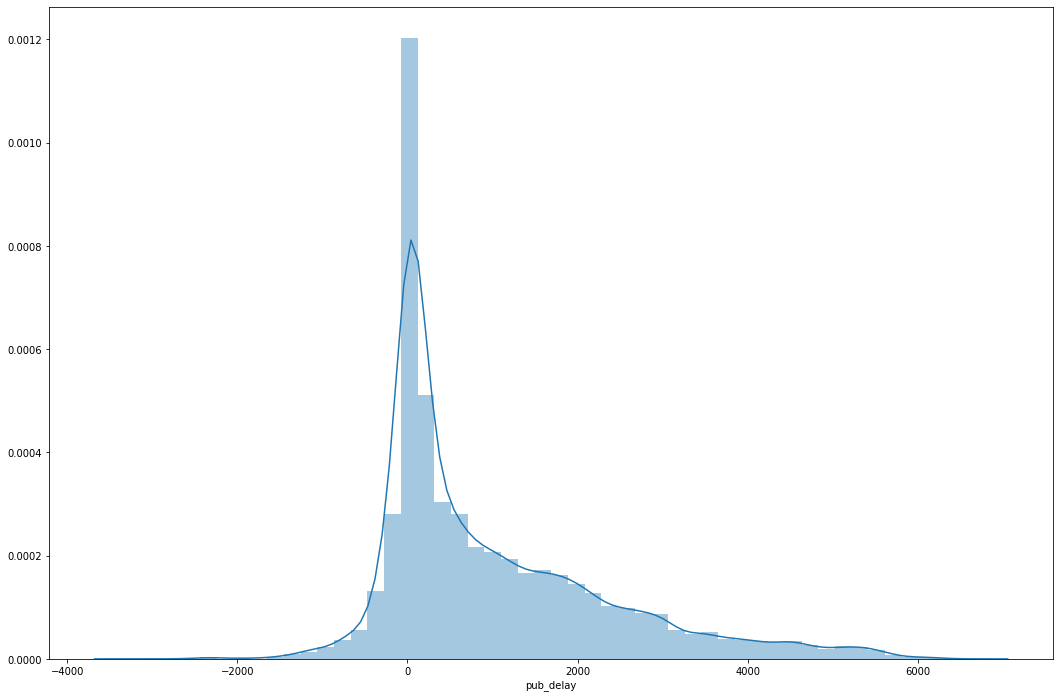

In [12]:
# plot timedelta distribution
fig_dims = (18,12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(gens['pub_delay'], ax = ax)